In [2]:
import pandas as pd
import numpy as np
import re

text_extract=pd.read_csv("training_dataset.csv")

def doi_finder(text):

    d=re.findall(r"(?<=Doi:).*",text,re.IGNORECASE)
    if len(d)==0:
        doi=None
    else:
        doi=d[0]

    text_full=re.sub(r"\nD..:.*","",text,re.IGNORECASE)
    return doi, text_full

def entity_finder(row):
    text=row["data"]
    pos_1=row["pos_1"]
    pos_2=row["pos_2"]
    entity=text[pos_1:pos_2]
    return entity

out=text_extract["data"].apply(doi_finder)
doi=[i[0] for i in out]
text=[i[1] for i in out]
text_extract["doi"]=doi
text_extract["data"]=text
text_extract["entity_label"]=text_extract["entity"]
text_extract.drop("entity",axis=1,inplace=True)
text_df=text_extract.dropna()
text_df["pos_1"]=text_df["pos_1"].astype(int)
text_df["pos_2"]=text_df["pos_2"].astype(int)
text_df["doi"]=text_df["doi"].apply(lambda x: x.replace("_","/"))
text_df["entity"]=text_df.apply(entity_finder,axis=1)

C:\Users\c23122695\AppData\Local\Temp\ipykernel_22872\3966859017.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_df["pos_1"]=text_df["pos_1"].astype(int)
C:\Users\c23122695\AppData\Local\Temp\ipykernel_22872\3966859017.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_df["pos_2"]=text_df["pos_2"].astype(int)
C:\Users\c23122695\AppData\Local\Temp\ipykernel_22872\3966859017.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

In [8]:
coarse_labels=pd.read_csv("label_config.csv")
label_dict={}
for name in coarse_labels.columns:
    for fine_grain in coarse_labels[name]:
        label_dict[fine_grain]=name
popper=list(label_dict.keys())[30]
label_dict.pop(popper)

def convert(fine_label):
    if fine_label in label_dict.keys():
        data=label_dict[fine_label]
    else:
        data=None
    return data

df=text_df.copy()
df["entity_label"]=df["entity_label"].apply(convert)

In [9]:
from nltk import sent_tokenize
def pos_adjustment(row):
    sample=row
    exm_data=sample["data"]
    pos1_=sample["pos_1"]
    pos2_=sample["pos_2"]
    get_len=re.findall(r"\w{3,}:",exm_data)
    tot_len=np.sum([len(i) for i in get_len])
    pos1=pos1_-tot_len
    pos2=pos2_-tot_len
    return pos1, pos2
df[["pos_1","pos_2"]]=df.apply(pos_adjustment,axis=1,result_type="expand")
df["data"]=df["data"].apply(lambda x:re.sub(r"\w{3,}:","",x))


In [10]:
from nltk import sent_tokenize
from nltk import word_tokenize
label_tags={
    "method": ["B-method", "I-method"],
    "material": ["B-material", "I-material"],
    "product": ["B-product", "I-product"],
    "Faradaicefficiency": ["B-Faradaicefficiency", "I-Faradaicefficiency"]
}

def sentence_processor(text):
    sample_row=text
    sentence=None
    entity_label=sample_row["entity_label"]
    sample_doi=sample_row["doi"]
    sample_text=sample_row["data"]
    entity=sample_row["entity"]
    pos_1=sample_row["pos_1"]
    pos_2=sample_row["pos_2"]
    tokenized_sentences=sent_tokenize(sample_text)
    char_count=0
    for i in tokenized_sentences:
        sent_length=len(i)
        if char_count<=pos_1<char_count+sent_length or char_count<=pos_2<char_count+sent_length:
            sentence=i
        char_count+=sent_length+1
    if sentence!=None and entity not in sentence:
        print(sentence, entity)
        sentence=None

    if sentence==None:
        return {"doi":sample_doi,"context":None,"entity":entity,"entity_label":entity_label,"original":sample_text,"position":(pos_1,pos_2)}
    else:
        return {"doi":sample_doi,"context":sentence,"entity":entity,"entity_label":entity_label,"original":sample_text,"position":(pos_1,pos_2)}
res=df.apply(sentence_processor,axis=1).to_list()
dfx=pd.DataFrame.from_records(res)

Sulfur (S)-modified Cu electrodes were reported to selectively reduce CO2 into formic acid and fully quench the original CO2 production on clean Cu surfaces, yet the actual mechanism is still unsolved.  Sulfur (S)-modified Cu electrodes
Cu nanocubes of similar to 70 nm in edge length are synthesized with {100} facets preferentially exposed on the surface.  Cu nanocubes of similar to 70 nm in edge length are synthesized with {100} facets preferentially exposed on the surface
The origin of the synergistic effect and the nature of the active phase are not well understood, thus hindering optimization efforts.  The origin of the synergistic effect and the nature of the active phase
A carbon-dots-based SAC margined with unique CuN2O2 sites was synthesized for the first time.  A carbon-dots-based SAC margined with unique CuN2O2 sites
Gold-in-copper at low *CO coverage enables efficient electromethanation of CO2
The renewable-electricity-powered CO2 electroreduction reaction provides a promisi

In [11]:
def fixit(data):
    text=data["original"]
    entity=data["entity"]
    context=data["context"]
    sentence=None
    if context==None:

        token_sent=sent_tokenize(text)

        for i in token_sent:
            if entity in i:
                sentence=i
        return sentence
    else:
        return context

dfx["context"]=dfx.apply(fixit,axis=1)


In [12]:
dfz=dfx.dropna()
count=0
dead_ent=[]

def tokenizer(test):
    test=test.copy()
    entity=test["entity"]
    label=test["entity_label"]
    context=test["context"]
    global count
    global dead_ent

    entity.strip()
    entity=entity.replace(","," ")
    entity=re.sub(r'(?<!\d)\.(?!\d)(?=\s|$)'," ", entity)
    pattern=r"FE(?=\w{1,5})"
    entity=re.sub(pattern,"FE ",entity)
    entity=entity.replace("-"," ")
    entity=entity.replace("("," ")
    entity=entity.replace(")"," ")
    entity=entity.replace("/"," ")

    entity=entity.replace("@"," ")

    entity=re.sub(r"\n"," ",entity)
    entity=word_tokenize(entity)

    context=context.strip()
    context=context.replace(","," ")
    context=re.sub(r'(?<!\d)\.(?!\d)(?=\s|$)'," ", context)
    pattern=r"FE(?=\w{1,5})"
    context=re.sub(pattern,"FE ",context)
    context=context.replace("-"," ")
    context=context.replace("("," ")
    context=context.replace(")"," ")
    context=context.replace("/"," ")

    context=context.replace("@"," ")
    context=re.sub(r"\n"," ",context)
    context=word_tokenize(context)
    vector=["O"]*len(context)

    for i in range(len(context)):
        if context[i:i+len(entity)]==entity:
            for j in range(len(entity)):
                vector[i+j]=1
            break
    oops=0
    for i in range(len(vector)):
        if vector[i]==1 and oops==0:
            vector[i]=label_tags[label][0]
            oops+=1
        elif vector[i]==1 and oops==1:
            vector[i]=label_tags[label][1]
    if all(i=="O" for i in vector):
        if entity[0]=="CO" and len(entity)==1:
            entity[0]="CO2"
            vector=["O"]*len(context)

            for i in range(len(context)):
                if context[i:i+len(entity)]==entity:
                    for j in range(len(entity)):
                        vector[i+j]=1
                    break
            oops=0
            for i in range(len(vector)):
                if vector[i]==1 and oops==0:
                    vector[i]=label_tags[label][0]
                    oops+=1
                elif vector[i]==1 and oops==1:
                    vector[i]=label_tags[label][1]
    if all(i=="O" for i in vector):
        count+=1
        dead_ent.append((context,entity))

    vector.insert(0,'[CLS]')
    vector.append('[SEP]')
    return context,vector
dfz[["tokens","ner_labels"]]=dfz.apply(tokenizer,axis=1,result_type="expand")
count


C:\Users\c23122695\AppData\Local\Temp\ipykernel_22872\559799822.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfz[["tokens","ner_labels"]]=dfz.apply(tokenizer,axis=1,result_type="expand")
C:\Users\c23122695\AppData\Local\Temp\ipykernel_22872\559799822.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfz[["tokens","ner_labels"]]=dfz.apply(tokenizer,axis=1,result_type="expand")


23

In [13]:
lab=[]
for i in list(label_tags.values()):
    for j in i:
        lab.append(j)

lab.insert(0,"O")

ner_tags={j:i for i,j in enumerate(lab)}
def ner_numerical(tokens):
    sample=tokens[1:-1]
    num_ner=[]
    for i in sample:
        num_ner.append(ner_tags[i])
    return num_ner
dfz["ner_tokens"]=dfz["ner_labels"].apply(ner_numerical)

C:\Users\c23122695\AppData\Local\Temp\ipykernel_22872\1535586095.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfz["ner_tokens"]=dfz["ner_labels"].apply(ner_numerical)


In [14]:
df_=dfz.loc[(dfz["ner_tokens"].apply(lambda x: not all(i==0 for i in x))),:]
df_combined=df_.groupby(["context"]).agg({"ner_tokens":lambda x:list(x),"entity_label":lambda x:list(x),"tokens":lambda x:list(x)}).reset_index()

def join_token(tokens):
    if len(tokens)>1:
        grouped=[0]*len(tokens[0])
        for ner in tokens:
            for i in range(len(ner)):
                if ner[i]!=0:
                    grouped[i]=ner[i]
        return grouped
    else:
        token=tokens[0]
        return token

df_combined["ner_tokens"]=df_combined["ner_tokens"].apply(join_token)
df_combined["tokens"]=df_combined["tokens"].apply(lambda x: x[0])

In [15]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb=MultiLabelBinarizer()

corpus=df_combined[['tokens','ner_tokens',"entity_label"]]
corpus.reset_index(inplace=True)
corpus.rename(columns={"index":"id"},inplace=True)
corpus.set_index("id",inplace=True)


encoded=mlb.fit_transform(corpus["entity_label"])
# corpus.drop("entity_label",inplace=True)
encoded=pd.DataFrame(encoded,columns=mlb.classes_)
full_corpus=pd.concat([corpus,encoded],axis=1)


In [16]:
from datasets import Dataset, DatasetDict
input_text=full_corpus[["tokens","ner_tokens"]]
def to_proc_data(data):
    out=Dataset.from_pandas(data,preserve_index=False)
    traintestvalid=out.train_test_split(test_size=0.2)
    test_valid=traintestvalid["test"].train_test_split(test_size=0.5)
    full_dataset=DatasetDict({
        "train":traintestvalid["train"],
        "test":test_valid["test"],
        "valid":test_valid["train"]
    })
    return full_dataset

full_dataset=to_proc_data(input_text)


c:\Users\c23122695\AppData\Local\anaconda3\envs\Thesis\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
# full_dataset.save_to_disk("revised_tags_2")
# input_text.to_csv("revised_tags_2.csv",index=False)

Saving the dataset (1/1 shards): 100%|██████████| 190/190 [00:00<00:00, 18999.57 examples/s]


In [180]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder

balance=df_[["entity_label","tokens","ner_tokens"]]
encoder=LabelEncoder()
oversample=RandomOverSampler(random_state=42)

X=balance.loc[:,(balance.columns!="entity_label")].values
y=balance.loc[:,(balance.columns=="entity_label")].values

y=encoder.fit_transform(y)
X,y=oversample.fit_resample(X,y)


egg=pd.DataFrame(X)
nog=pd.DataFrame(y)
inputdata=pd.concat([egg,nog],axis=1)
inputdata.columns=['tokens', 'ner_tokens' ,'entity_label']
inputdata.drop("entity_label",axis=1,inplace=True)

c:\Users\c23122695\AppData\Local\anaconda3\envs\Thesis\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [184]:
# unprocessed=to_proc_data(inputdata)
# unprocessed.save_to_disk("unprocessed_tags")

<Axes: xlabel='Coarse Grain Label', ylabel='Count'>

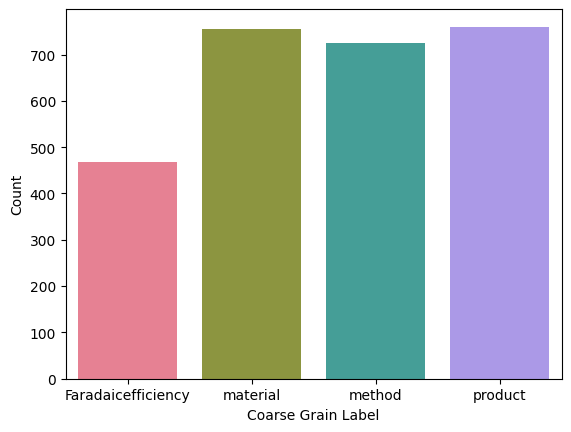

In [209]:
import matplotlib.pyplot as plt
import seaborn as sns

grouped_total=full_corpus.iloc[:,-4:].sum()
grouped_total=pd.DataFrame(grouped_total)
grouped_total.reset_index(inplace=True)
grouped_total.columns=["Coarse Grain Label","Count"]

fig, ax=plt.subplots()

sns.barplot(grouped_total,x="Coarse Grain Label",y="Count",hue="Coarse Grain Label",palette="husl")

C:\Users\c23122695\AppData\Local\Temp\ipykernel_22872\728049812.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45,fontdict={"fontsize":7})


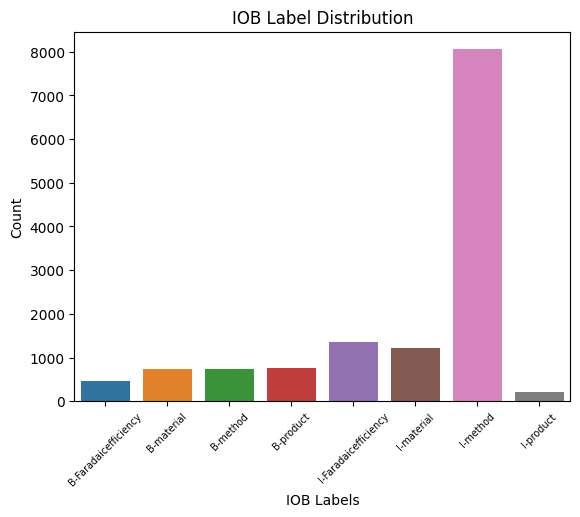

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

id2label={0: 'O',
        1: 'B-method',
        2: 'I-method',
        3: 'B-material',
        4: 'I-material',
        5: 'B-product',
        6: 'I-product',
        7: 'B-Faradaicefficiency',
        8: 'I-Faradaicefficiency'
        }
all_tokens=[]
input_text["ner_tokens"].apply(lambda x: all_tokens.extend(x))
# all_tokens=[id2label[i] for i in all_tokens if i!=0]#

labels, counts=np.unique(all_tokens,return_counts=True)
fig, ax= plt.subplots()
sns.barplot(x=labels,y=counts,hue=labels)
plt.title('IOB Label Distribution')
plt.ylabel('Count')
plt.xlabel('IOB Labels')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45,fontdict={"fontsize":7})
plt.show()